In [37]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [7]:
df = pd.read_csv("../Data/raw/wallet_features.csv")

In [8]:
df['label'] = df['label'].replace(2, 1)

In [9]:
df.label.value_counts()

label
1    56
0     8
Name: count, dtype: int64

In [28]:
X = df.drop(columns=["wallet_address", "label"])
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Apply SMOTE only on training
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)

# **Training the models**

### **Settingup Hyper-parameters**

In [24]:
models = {
    "LogisticRegression": {
        "model": LogisticRegression(solver='liblinear', class_weight='balanced'),
        "params": {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l1", "l2"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(class_weight='balanced'),
        "params": {
            "clf__n_estimators": [50, 100, 200],
            "clf__max_depth": [None, 5, 10],
            "clf__min_samples_split": [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "clf__n_estimators": [50, 100, 200],
            "clf__max_depth": [3, 5, 10],
            "clf__learning_rate": [0.01, 0.1, 0.2],
            "clf__scale_pos_weight": [1, 1.5, 2]
        }
    }
}

results = {}

### **Training**

In [30]:
for name, cfg in models.items():
    print(f"\n🔍 Training {name}")
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", cfg["model"])
    ])
    searcher = RandomizedSearchCV(
        pipe,
        cfg["params"],
        cv=5,
        n_iter=10,
        scoring='f1',
        random_state=42,
        n_jobs=-1
    )
    searcher.fit(X_train, y_train)

    best_model = searcher.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    results[name] = {
        "model": best_model,
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "log_loss": log_loss(y_test, y_prob)
    }


🔍 Training LogisticRegression


c:\Users\shyam\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



🔍 Training RandomForest

🔍 Training XGBoost


c:\Users\shyam\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:03:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 LogisticRegression - AUC: 1.0000, Log Loss: 0.0074
              precision  recall  f1-score  support
0                   1.0     1.0       1.0      2.0
1                   1.0     1.0       1.0     11.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     13.0
weighted avg        1.0     1.0       1.0     13.0


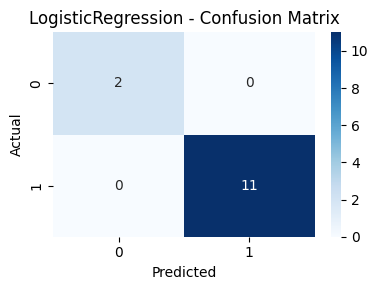


📊 RandomForest - AUC: 1.0000, Log Loss: 0.0000
              precision  recall  f1-score  support
0                   1.0     1.0       1.0      2.0
1                   1.0     1.0       1.0     11.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     13.0
weighted avg        1.0     1.0       1.0     13.0


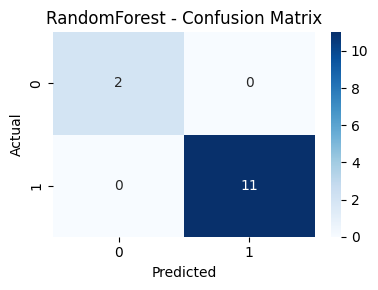


📊 XGBoost - AUC: 1.0000, Log Loss: 0.0569
              precision  recall  f1-score  support
0                   1.0     1.0       1.0      2.0
1                   1.0     1.0       1.0     11.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     13.0
weighted avg        1.0     1.0       1.0     13.0


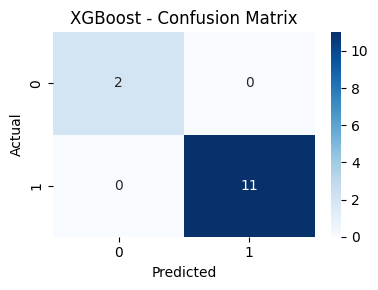

In [31]:
# ----- Evaluation Plots -----
for name, res in results.items():
    print(f"\n📊 {name} - AUC: {res['roc_auc']:.4f}, Log Loss: {res['log_loss']:.4f}")
    df_report = pd.DataFrame(res["classification_report"]).T
    print(df_report)

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(res["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

### **Correlation of Features with Target**

C:\Users\shyam\AppData\Local\Temp\ipykernel_28904\881334774.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


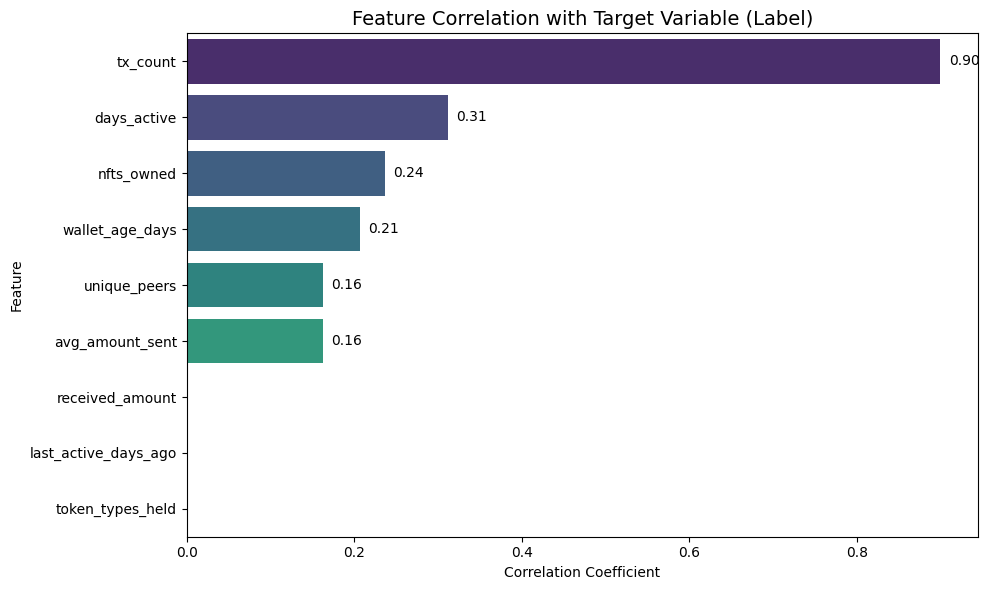

In [32]:
df_numeric = df.drop(columns=["wallet_address"])

# Calculate correlation with target
correlation_with_label = df_numeric.corr()["label"].drop("label").sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    x=correlation_with_label.values,
    y=correlation_with_label.index,
    palette="viridis"
)

plt.title("Feature Correlation with Target Variable (Label)", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")

# Add data labels
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

In [38]:
joblib.dump(results['LogisticRegression']['model'], '../Trained Model/LR_Trained_Model.pkl')

['../Trained Model/LR_Trained_Model.pkl']